In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

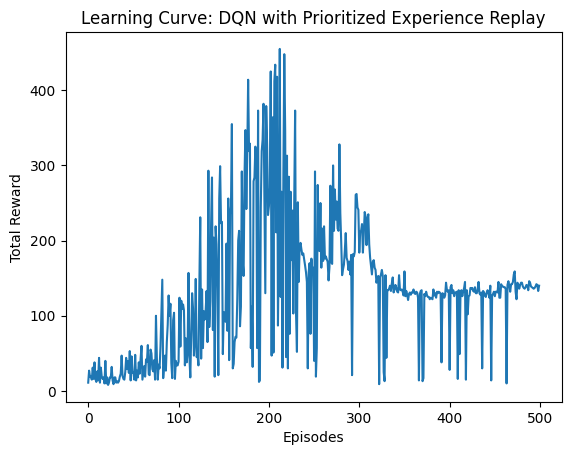

In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import random

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = []
        self.priorities = deque(maxlen=capacity)
        self.position = 0
        self.alpha = alpha

    def push(self, transition, td_error):
        max_priority = max(self.priorities, default=1.0)
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.position] = transition
        self.priorities.append(max_priority if td_error is None else abs(td_error) ** self.alpha)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        scaled_priorities = np.array(self.priorities) ** beta
        sampling_probs = scaled_priorities / scaled_priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=sampling_probs)
        samples = [self.buffer[idx] for idx in indices]
        return samples, indices, sampling_probs[indices]

    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = abs(td_error) ** self.alpha

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            return policy_net(torch.FloatTensor(state)).argmax().item()

env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
memory = PrioritizedReplayBuffer(10000)
episodes = 500
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
win_rate, draw_rate, lose_rate = 0, 0, 0
rewards_list = []

for episode in range(episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False
    while not done:
        action = select_action(state, epsilon)  # Use ε-greedy action selection
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        
        with torch.no_grad():
            target_q = reward + gamma * target_net(torch.FloatTensor(next_state)).max().item() * (1 - done)
        current_q = policy_net(torch.FloatTensor(state))[action].item()
        td_error = abs(target_q - current_q)
        memory.push((state, action, reward, next_state, done), td_error)
        
        # Track win, draw, and lose outcomes
        if done:
            if total_reward >= 500:
                win_rate += 1
            elif total_reward >= 400:
                draw_rate += 1
            else:
                lose_rate += 1

        if len(memory.buffer) > batch_size:
            batch, indices, sampling_probs = memory.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)

            current_q = policy_net(states).gather(1, actions)
            max_next_q = target_net(next_states).max(1)[0]
            expected_q = rewards + (gamma * max_next_q * (1 - dones))

            loss = (current_q - expected_q.unsqueeze(1)).pow(2) * torch.FloatTensor(sampling_probs).unsqueeze(1)
            loss = loss.mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            new_td_errors = abs(expected_q - current_q.squeeze(1)).detach().cpu().numpy()
            memory.update_priorities(indices, new_td_errors)

        state = next_state

    rewards_list.append(total_reward)
    epsilon = max(epsilon_min, epsilon_decay * epsilon)  
    if episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())

plt.plot(rewards_list)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Learning Curve: DQN with Prioritized Experience Replay")
plt.show()

